In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2e77ccddca89e7deebf136030924df2ad315d294e7f2051946a9e240cb9a8f1e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import time
import gc
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import col, lower
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

#ALS

In [ ]:
data_path = '/content/drive/MyDrive/USML_mid_project'
ratings_filename = 'ratings_processed_int.csv'
restau_filename = 'restau_processed_int.csv'

## Evaluation Metrics

In [ ]:
def mean_reciprocal_rank(rs):
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def eval_metrics(df, max_k):
    precision_k = {}
    # recall_k = {}
    ndcg_k = {}

    unique_users = set(df['user_id'].unique())
    hit_arrays = []

    for user in unique_users:
        hit_arr = df[df['user_id']==user]['hit']
        # df_user = df[df['user_id']==user][['y_actual', 'y_recommended']]
        max_user_k = min(max_k, len(hit_arr))

        for k in range(1, max_user_k+1):
#             prec = precision_at_k(df_user, k, 'y_actual', 'y_recommended')
            # rec = recall_at_k(df_user, k, 'y_actual', 'y_recommended')
            prec = precision_at_k(hit_arr, k)
#             rec = recall_at_k(df_user, k)
            ndcg = ndcg_at_k(hit_arr, k)

            if k in precision_k.keys():
                precision_k[k].append(prec)
                # recall_k[k].append(rec)
                ndcg_k[k].append(ndcg)
            else:
                precision_k[k] = [prec]
                # recall_k[k] = [rec]
                ndcg_k[k] = [ndcg]

        hit_arrays.append(hit_arr)


    mrr = mean_reciprocal_rank(hit_arrays)
    maprec = mean_average_precision(hit_arrays)

    final_precision = []
    for k,v in precision_k.items():
        final_precision.append(np.mean([prec for prec in precision_k[k] if prec != None]))

    # final_recall = []
    # for k,v in recall_k.items():
    #     final_recall.append(np.mean([rec for rec in recall_k[k] if rec != None]))

    final_ndcg = []
    for k,v in ndcg_k.items():
        final_ndcg.append(np.mean([ndcg for ndcg in ndcg_k[k] if ndcg != 0]))

    return {
        'precision': final_precision,
        # 'recall': final_recall,
        'map': maprec,
        'mrr': mrr,
        'ndcg': final_ndcg
           }

def recall_at_k(df: pd.DataFrame, k: int, y_test: str, y_pred: str) -> float:
    dfK = df.head(k)
    denominator = df[y_test].sum()
    numerator = dfK[dfK[y_pred] & dfK[y_test]].shape[0]
    if denominator > 0:
        return numerator/denominator
    else:
        return None

def recall_over_k(df, max_k):
    recall_k = {}

    unique_users = set(df['user_id'].unique())

    for user in unique_users:
        df_user = df[df['user_id']==user][['y_actual', 'y_recommended']]
        max_user_k = min(max_k, len(df_user))

        for k in range(1, max_user_k+1):
            rec = recall_at_k(df_user, k, 'y_actual', 'y_recommended')

            if k in recall_k.keys():
                recall_k[k].append(rec)
            else:
                recall_k[k] = [rec]

    final_recall = []
    for k,v in recall_k.items():
        final_recall.append(np.mean([rec for rec in recall_k[k] if rec != None]))

    return final_recall


## Baseline

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/USML_mid_project/ratings_sample_int.csv', header=True, inferSchema=True)

In [ ]:
from pyspark.sql.types import IntegerType
df = df.withColumn("user_id", df["user_id"].cast(IntegerType()))
df = df.withColumn("business_id", df["business_id"].cast(IntegerType()))

In [ ]:
df = df.withColumn("rating", df["rating"].cast(IntegerType()))

In [ ]:
nd=df.select(df['business_id'],df['rating'],df['user_id'])
nd.show()

+-----------+------+-------+
|business_id|rating|user_id|
+-----------+------+-------+
|       9150|     4| 171989|
|       9891|     4| 171989|
|      12592|     4| 171989|
|       4971|     5| 171989|
|       7782|     5|   2863|
|      12550|     4|   2863|
|       4046|     5|   2863|
|       4729|     5|   2863|
|       7269|     5|   2863|
|      14190|     4|   2863|
|      11233|     5|   2863|
|       NULL|  NULL|   NULL|
|        388|     4|   2863|
|       NULL|  NULL|   NULL|
|      10928|     4|   2863|
|       NULL|  NULL|   NULL|
|       9838|     5|  18980|
|      10352|     5|  18980|
|      11573|     3|  18980|
|       NULL|  NULL|   NULL|
+-----------+------+-------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import isnan, when, count, col

nd.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in nd.columns]).show()


+-----------+------+-------+
|business_id|rating|user_id|
+-----------+------+-------+
|     266869|266896| 266875|
+-----------+------+-------+



In [ ]:
nd.dtypes

[('business_id', 'int'), ('rating', 'int'), ('user_id', 'int')]

In [ ]:
nd = nd.na.drop()

In [ ]:
print((nd.count(), len(nd.columns)))

(201480, 3)


In [ ]:
(training,test)=nd.randomSplit([0.8, 0.2])

In [ ]:
als=ALS(maxIter=5,regParam=0.09,rank=25,userCol="user_id",itemCol="business_id",ratingCol="rating",coldStartStrategy="drop")

In [ ]:
als_model=als.fit(training)

In [ ]:
evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="prediction")

In [ ]:
als_predictions = als_model.transform(test)

In [ ]:
als_rmse = evaluator.evaluate(als_predictions)
print("RMSE="+str(als_rmse))

RMSE=1.6810716176893656


In [ ]:
als_model.write().overwrite().save(os.path.join(data_path, 'als_sample'))

In [ ]:
als_pred_df = als_predictions.toPandas()

In [ ]:
als_pred_df.head()

,business_id,rating,user_id,prediction
0,268,4,7554,1.512171
1,276,4,7554,1.933115
2,556,3,12799,3.597072
3,589,5,7554,4.230498
4,671,2,12799,2.554398


In [ ]:
als_pred_df.sort_values(by='prediction',ascending=False,inplace=True)
# remove rows with missing values
als_pred_df.dropna(inplace=True)

In [ ]:
threshold = 3.5

In [ ]:
als_pred_df['y_actual'] = als_pred_df['rating'] >= threshold
als_pred_df['y_recommended'] = als_pred_df['prediction'] >= threshold

In [ ]:
als_pred_df['hit'] = als_pred_df['y_actual'] & als_pred_df['y_recommended']
als_pred_df['hit'] = als_pred_df['hit'].apply(lambda x: 1 if x else 0)

In [ ]:
TOP_K = 10

In [ ]:
als_sample_metrics = eval_metrics(als_pred_df, TOP_K)

In [ ]:
print('ALS Model MRR: ', als_sample_metrics['mrr'])
print('ALS Model MAP: ', als_sample_metrics['map'])

ALS Model MRR:  0.3747155838998294
ALS Model MAP:  0.37199047971500343


In [ ]:
als_sample_recall = recall_over_k(als_pred_df, TOP_K)

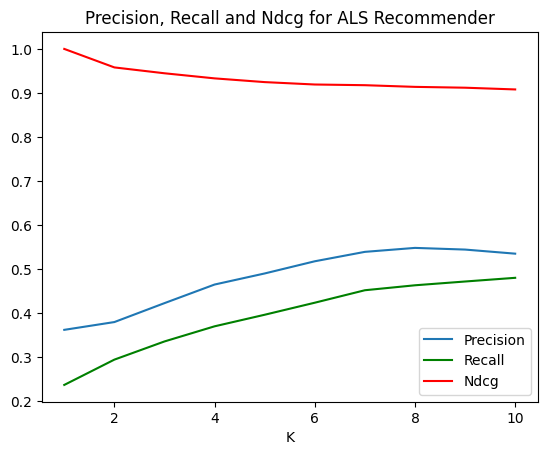

In [ ]:
plt.plot(np.arange(1,len(als_sample_metrics['precision'])+1), als_sample_metrics['precision'])
plt.plot(np.arange(1,len(als_sample_recall)+1), als_sample_recall, color='g')
plt.plot(np.arange(1,len(als_sample_metrics['ndcg'])+1), als_sample_metrics['ndcg'], color='r')

plt.xlabel('K')
plt.title('Precision, Recall and Ndcg for ALS Recommender')
plt.legend(["Precision", 'Recall', "Ndcg"], loc="lower right");

## Hyperparameter Tuning

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

param_grid = ParamGridBuilder().addGrid(als.rank, [10, 25, 50]).addGrid(als.maxIter, [5, 10]).addGrid(als.regParam, [0.05, 0.1]).build()

from pyspark.ml.tuning import CrossValidator

cv = CrossValidator (estimator = als, estimatorParamMaps = param_grid, evaluator = evaluator, numFolds= 2)

sample_hyp_model = cv.fit(training)

als_sample_hyp_model = sample_hyp_model.bestModel

In [ ]:
type(als_sample_hyp_model), type(sample_hyp_model)

(pyspark.ml.recommendation.ALSModel, pyspark.ml.tuning.CrossValidatorModel)

In [ ]:
als_sample_hyp_model.write().save(os.path.join(data_path, 'als_sample_hyp'))

In [ ]:
als_sample_hyp_predictions = als_sample_hyp_model.transform(test)

In [ ]:
als_sample_hyp_rmse = evaluator.evaluate(als_sample_hyp_predictions)
print("RMSE="+str(als_sample_hyp_rmse))

RMSE=1.4108004622779693


In [ ]:
als_sample_hyp_pred_df = als_sample_hyp_predictions.toPandas()

In [ ]:
als_sample_hyp_pred_df.sort_values(by='prediction',ascending=False,inplace=True)

als_sample_hyp_pred_df.dropna(inplace=True)

In [ ]:
als_sample_hyp_pred_df['y_actual'] = als_sample_hyp_pred_df['rating'] >= threshold
als_sample_hyp_pred_df['y_recommended'] = als_sample_hyp_pred_df['prediction'] >= threshold

In [ ]:
als_sample_hyp_pred_df['hit'] = als_sample_hyp_pred_df['y_actual'] & als_sample_hyp_pred_df['y_recommended']
als_sample_hyp_pred_df['hit'] = als_sample_hyp_pred_df['hit'].apply(lambda x: 1 if x else 0)

In [ ]:
als_sample_hyp_metrics = eval_metrics(als_sample_hyp_pred_df, TOP_K)

In [ ]:
print('ALS Tuned Model MRR: ', als_sample_hyp_metrics['mrr'])
print('ALS Tuned Model MAP: ', als_sample_hyp_metrics['map'])

ALS Tuned Model MRR:  0.45117036933211857
ALS Tuned Model MAP:  0.4481998874627457


In [ ]:
als_sample_hyp_recall = recall_over_k(als_sample_hyp_pred_df, TOP_K)

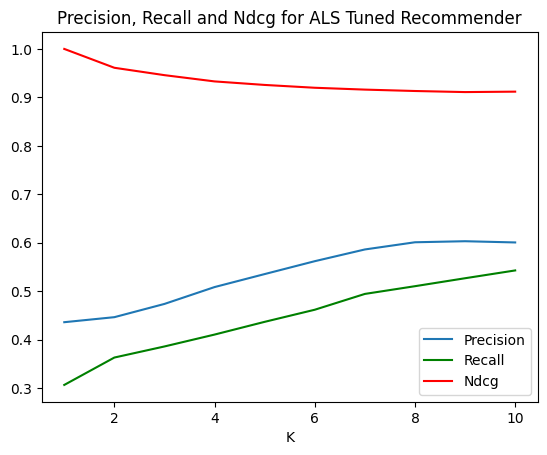

In [ ]:
plt.plot(np.arange(1,len(als_sample_hyp_metrics['precision'])+1), als_sample_hyp_metrics['precision'])
plt.plot(np.arange(1,len(als_sample_hyp_recall)+1), als_sample_hyp_recall, color='g')
plt.plot(np.arange(1,len(als_sample_hyp_metrics['ndcg'])+1), als_sample_hyp_metrics['ndcg'], color='r')

plt.xlabel('K')
plt.title('Precision, Recall and Ndcg for ALS Tuned Recommender')
plt.legend(["Precision", 'Recall', "Ndcg"], loc="lower right");

In [ ]:
als_sample_hyp_pred_df.head()

,business_id,rating,user_id,prediction,y_actual,y_recommended,hit
24886,8413,5,115096,5.744863,True,True,1
7756,18553,5,6449,5.727728,True,True,1
31320,6040,5,178257,5.631851,True,True,1
6535,4615,5,19398,5.612540,True,True,1
3566,7614,3,30155,5.578245,False,True,0


In [ ]:
als_sample_hyp_pred_df.iloc[:3]

,business_id,rating,user_id,prediction,y_actual,y_recommended,hit
24886,8413,5,115096,5.744863,True,True,1
7756,18553,5,6449,5.727728,True,True,1
31320,6040,5,178257,5.631851,True,True,1


In [ ]:
test.schema.names

['business_id', 'rating', 'user_id']

In [ ]:
recommend_user = spark.createDataFrame(als_sample_hyp_pred_df.iloc[:3][['user_id']])

In [ ]:
recommend_user.schema.names

['user_id']

In [ ]:
userSubsetRecs = als_sample_hyp_model.recommendForUserSubset(recommend_user, 10)

In [ ]:
user_recs = userSubsetRecs.toPandas()

In [ ]:
import pickle
with open('/content/drive/MyDrive/USML_mid_project/restau_sample_idx_to_id_mapper.pickle', 'rb') as handle:
    restau_sample_idx_to_id_mapper = pickle.load(handle)


In [ ]:
als_sample_hyp_pred_df[als_sample_hyp_pred_df['user_id']==115096]['business_id'][:3][:4]

24886     8413
24926    12936
24909    11120
Name: business_id, dtype: int32

In [ ]:
for row in user_recs.iterrows():
  print('User: ', row[1][0])

  visited = als_sample_hyp_pred_df[als_sample_hyp_pred_df['user_id']==row[1][0]]['business_id'][:3]
  print('Visited restaurants:')
  for visit_restau in visited:
    print(restau_sample_idx_to_id_mapper[visit_restau][1])
  # print(als_sample_hyp_pred_df[['user_id']==row[1][0]]['business_id'])

  print('\nRecommendations:')
  recs = row[1][1]
  # cnt=0
  for recomm in recs[:9]:
    # print(recomm[0])

    print(restau_sample_idx_to_id_mapper[recomm[0]][1])
    # print([restau_sample_idx_to_id_mapper[recomm[0]][1] for recomm in recs])
  print()

User:  115096
Visited restaurants:
Fat Guy's Fresh Deli
Pad Thai House
Goldy's Breakfast Bistro

Recommendations:
Island Sushi & Ramen
Pueblo Lindo
Fat Guy's Fresh Deli
Shogun Sushi
The Front Door
Epi's A Basque Restaurant
Das Alpenhaus Delikatessen
Country Donuts
Dutch Bros Coffee

User:  6449
Visited restaurants:
Coffee Times Drive
North Italia
Sunny Daze Cafe

Recommendations:
Selena's Salvadorian
Starr Pass Golf Club
Barrio Bread
It's Greek To Me
Barista Del Barrio
El Antojo Poblano
Molecular Munchies
Primo with Patio Dining
Ensenada Street Food

User:  178257
Visited restaurants:
Bangkok Kitchen Thai Restaurant

Recommendations:
Cafe Soleil
Asian House
Hamilton's Urban Steakhouse and Bourbon Bar
Bangkok Kitchen Thai Restaurant
Cricketers British Pub & Restaurant - Dunedin
Yolk White & Associates
Alberto's Cheese & Wine Bistro
Sultān Mediterranean Restaurant
Oakleys Bistro

